# Compare dispersion curves: `hvswdpy` Vs. `Disba` 

This notebook computes Rayleigh and Love phase-velocity dispersion curves using both:

- [hvswdpy](https://github.com/Shihao-Yuan/SWD-HV-DFA)
- [Disba](https://github.com/keurfonluu/disba)

It uses the layered model in `examples/models/model.txt` and compares results on the same frequency grid.


In [1]:
import sys
from pathlib import Path
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import lineStyles


# SRC_PATH = Path("../src") # relative to this notebook
# SCRIPT_DIR = Path("./") # current directory

try:
    SCRIPT_DIR = Path(__file__).resolve().parent
except NameError:
    SCRIPT_DIR = Path.cwd().resolve()
SRC_PATH = SCRIPT_DIR.parent / 'src'

# Ensure Python can import from src if not installed
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

# Try hvswdpy import
try:
    import hvswdpy as hv
except Exception as e:
    print('Import failed, attempting to build Python extension via setup.py ...')
    subprocess.run([sys.executable, 'setup.py', 'build_ext', '--inplace'], cwd=str(SRC_PATH), check=True)
    import hvswdpy as hv

# Disba import
try:
    from disba import PhaseDispersion
except ModuleNotFoundError as e:
    raise ModuleNotFoundError(
        "Disba is not installed. Install with `pip install disba` in your environment."
    ) from e


In [ ]:
# Load model from examples/models/model.txt 

def read_model(path: Path):
    with open(path, 'r') as f:
        lines = [ln.strip() for ln in f if ln.strip()]
    n = int(lines[0])
    vp, vs, rho, th = [], [], [], []
    for i in range(1, n + 1):
        t, a, b, d = lines[i].split()
        if i < n:
            th.append(float(t)) 
        vp.append(float(a))
        vs.append(float(b))
        rho.append(float(d))
    return (
        np.array(vp, dtype=float),
        np.array(vs, dtype=float),
        np.array(rho, dtype=float),
        np.array(th, dtype=float),
    )

model_file = SCRIPT_DIR / 'models/model.txt'
VP, VS, RHO, TH = read_model(model_file)

print('Model layers:')              
for i in range(VP.size):
    lay = 'layer' if i < VP.size - 1 else 'half-space'
    t = TH[i] if i < TH.size else 0.0
    print(f"  {i+1} ({lay}): th={t} m, vp={VP[i]} m/s, vs={VS[i]} m/s, rho={RHO[i]} kg/m^3")


Model layers:
  1 (layer): th=20.0 m, vp=300.0 m/s, vs=150.0 m/s, rho=1800.0 kg/m^3
  2 (half-space): th=0.0 m, vp=1500.0 m/s, vs=800.0 m/s, rho=2200.0 kg/m^3


In [3]:
# Define frequency/period grids and common settings
NF = 80
FMIN, FMAX = 0.5, 40.0
FREQ = np.logspace(np.log10(FMIN), np.log10(FMAX), NF)
PERIOD = 1.0 / FREQ

N_RAY_MODES = 5
N_LOVE_MODES = 5
PREC = 1 #0.01  

In [4]:
# Compute dispersion with hvswdpy

disp = hv.dispersion(
    frequencies_hz=FREQ,
    vp=VP, vs=VS, rho=RHO, thickness=TH,
    n_rayleigh_modes=N_RAY_MODES, n_love_modes=N_LOVE_MODES, precision_percent=PREC,
)

ray_sl = disp.rayleigh_slowness  
ray_va = disp.rayleigh_valid     
lov_sl = disp.love_slowness      
lov_va = disp.love_valid         

ray_vel_hv = np.where(ray_sl > 0, 1.0 / ray_sl, np.nan)
lov_vel_hv = np.where(lov_sl > 0, 1.0 / lov_sl, np.nan)

print('HV-SWD-DFA:')
print('  Rayleigh valid points:', int(np.sum(ray_va != 0)))
print('  Love valid points:', int(np.sum(lov_va != 0)))


HV-SWD-DFA:
  Rayleigh valid points: 237
  Love valid points: 194


/var/folders/0f/qh8vgw8n4g570f0r6q17pdz00000gn/T/ipykernel_36133/3459271852.py:14: RuntimeWarning: divide by zero encountered in divide
  ray_vel_hv = np.where(ray_sl > 0, 1.0 / ray_sl, np.nan)
/var/folders/0f/qh8vgw8n4g570f0r6q17pdz00000gn/T/ipykernel_36133/3459271852.py:15: RuntimeWarning: divide by zero encountered in divide
  lov_vel_hv = np.where(lov_sl > 0, 1.0 / lov_sl, np.nan)


In [5]:
# Compute dispersion with Disba
# Disba expects thickness [km], velocities [km/s], density [g/cm^3]
# Convert from current units: m, m/s, kg/m^3

# Append 0.0 for half-space thickness for Disba
th_km = np.append(TH, 0.0) / 1000.0
vp_kms = VP / 1000.0
vs_kms = VS / 1000.0
rho_gcm3 = RHO / 1000.0  # 1000 kg/m^3 = 1 g/cm^3

pd_ray = PhaseDispersion(th_km, vp_kms, vs_kms, rho_gcm3,dc=0.001)
pd_lov = PhaseDispersion(th_km, vp_kms, vs_kms, rho_gcm3,dc=0.001)

# Use ascending period for Disba, then reverse to match FREQ ascending 
PER_ASC = PERIOD[::-1]
N_PER = PER_ASC.size

def compute_mode_velocity(pd_obj, wave, mode):
    res = pd_obj(PER_ASC, wave=wave, mode=mode)
    vel = np.asarray(res.velocity).ravel()
    if hasattr(res, 'period'):
        p_ret = np.asarray(res.period).ravel()
    else:
        p_ret = PER_ASC
    full = np.full(N_PER, np.nan, dtype=float)
    key_grid = np.round(PER_ASC, 12)
    key_ret = np.round(p_ret, 12)
    index_by_period = {val: idx for idx, val in enumerate(key_grid)}
    for j, pr in enumerate(key_ret):
        idx = index_by_period.get(pr)
        if idx is not None and j < vel.size:
            full[idx] = vel[j]
    return full

ray_vel_disba = []
for m in range(N_RAY_MODES):
    full = compute_mode_velocity(pd_ray, 'rayleigh', m)
    ray_vel_disba.append(full[::-1])
ray_vel_disba = np.stack(ray_vel_disba, axis=1)  

lov_vel_disba = []
for m in range(N_LOVE_MODES):
    full = compute_mode_velocity(pd_lov, 'love', m)
    lov_vel_disba.append(full[::-1])
lov_vel_disba = np.stack(lov_vel_disba, axis=1)  

print('Disba computed.')


Disba computed.


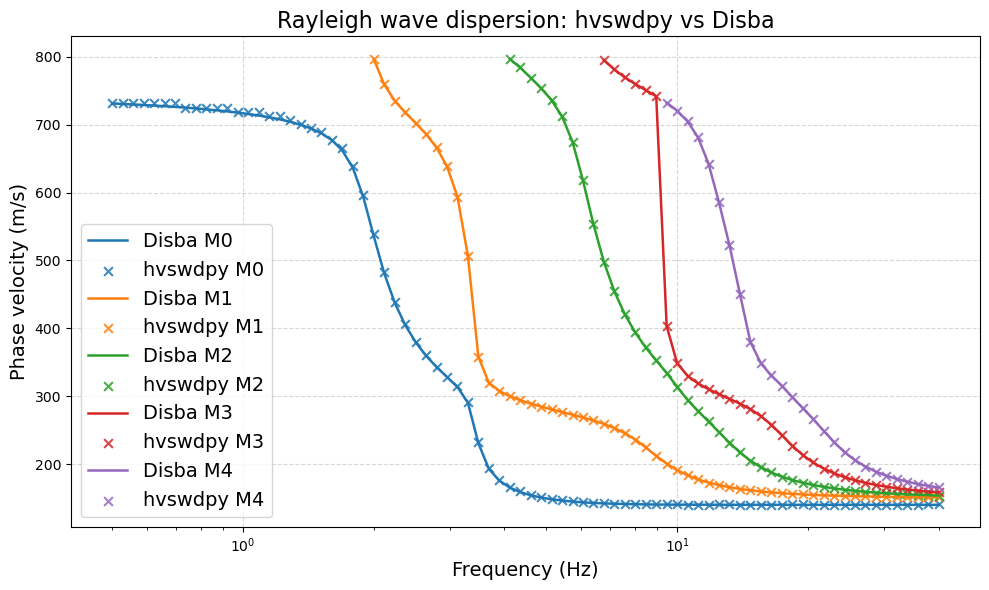

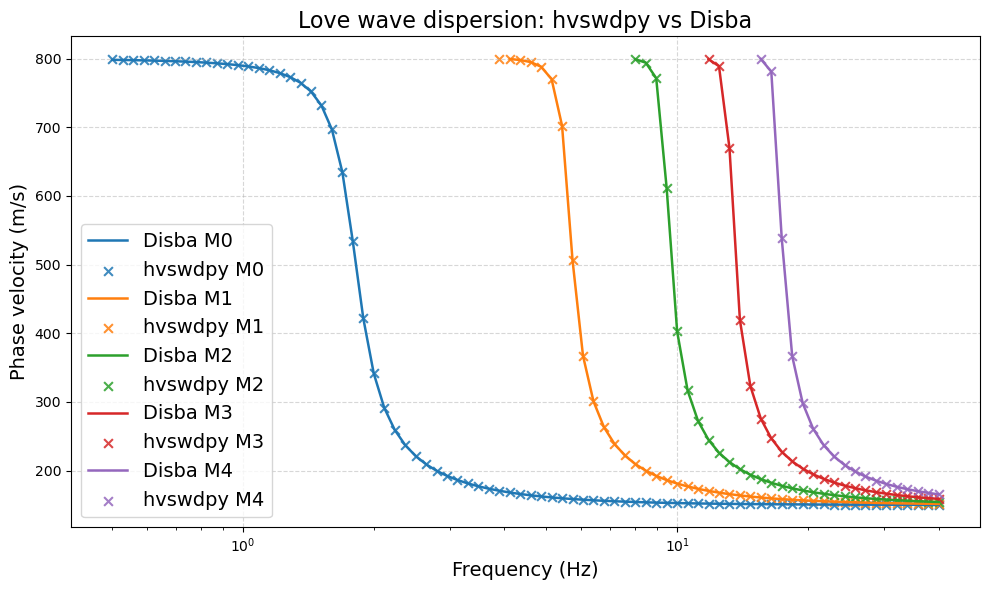

In [6]:
# Overlay comparison

colors = [f"C{i}" for i in range(max(N_RAY_MODES, N_LOVE_MODES))]

plt.figure(figsize=(10, 6))
for m in range(min(N_RAY_MODES, ray_vel_disba.shape[1])):
    # Disba lines
    plt.plot(FREQ, ray_vel_disba[:, m] * 1000.0, '-', lw=1.8, color=colors[m % len(colors)], label=f"Disba M{m}")
    # HV-SWD-DFA 
    mask = (ray_va[:, m] != 0)
    if np.any(mask):
        plt.scatter(FREQ[mask], ray_vel_hv[mask, m], marker='x', s=40, color=colors[m % len(colors)], alpha=0.85, label=f"hvswdpy M{m}")
plt.xscale('log')
plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('Phase velocity (m/s)', fontsize=14)
plt.title('Rayleigh wave dispersion: hvswdpy vs Disba',fontsize=16)
plt.grid(True, linestyle='dashed', alpha=0.5)
plt.legend(ncol=1, fontsize=14,loc=3)
plt.tight_layout()
plt.show()

# Love overlay
plt.figure(figsize=(10, 6))
for m in range(min(N_LOVE_MODES, lov_vel_disba.shape[1])):
    # Disba 
    plt.plot(FREQ, lov_vel_disba[:, m] * 1000.0, '-', lw=1.8, color=colors[m % len(colors)], label=f"Disba M{m}")
    # HV-SWD-DFA 
    mask = (lov_va[:, m] != 0)
    if np.any(mask):
        plt.scatter(FREQ[mask], lov_vel_hv[mask, m], marker='x', s=40, color=colors[m % len(colors)], alpha=0.85, label=f"hvswdpy M{m}")
plt.xscale('log')
plt.xlabel('Frequency (Hz)',fontsize=14)
plt.ylabel('Phase velocity (m/s)',fontsize=14)
plt.title('Love wave dispersion: hvswdpy vs Disba',fontsize=16)
plt.grid(True, linestyle='dashed', alpha=0.5)
plt.legend(ncol=1, fontsize=14,loc=3)
plt.tight_layout()
plt.show()
